## Purpose

The notebook explores keypoint detection techniques to identify the volume within 
the LV (left ventricle) as a set of grid lines. The lines are used to calculate the LV volume at the corresponding cardiac phase. We use the EchoNet-Dynamic data as input for this exploration. The data already has tracings for the ES and the ED frame. The LV volume calculated as both ED and ES phase is used for Ejection fraction calculation, which is a crucial measure of heart function.

In [ ]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [ ]:
!python -c "import SimpleITK" || pip install -q SimpleITK
!python -c "import medpy" || pip install -q medpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import PIL
import cv2
import os
import shutil
import tempfile
from pathlib import Path

In [4]:
## Code to clean kaggle output folders
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                #remove_folder_contents(file_path)
                #os.rmdir(file_path)
                continue
        except Exception as e:
            print(e)

In [4]:
#folder_path = '/kaggle/working'
#remove_folder_contents(folder_path)

### Set Data Directory to where you want all the data and processing artifacts to be

If using Kaggle

In [3]:
%env DATA_DIRECTORY = /kaggle/input

env: DATA_DIRECTORY=/kaggle/input


If using Google Drive

In [ ]:
%env DATA_DIRECTORY = /content/drive/MyDrive/LVEF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

If using a local directory

In [ ]:
%env DATA_DIRECTORY = /opt/Data

### Set the Root Directory

In [5]:
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

/kaggle/input


In [6]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

Get the data and setup the input directories

In [7]:
ECHONET_DATA_DIR = 'heartdatabase/EchoNet-Dynamic'

In [8]:
import pprint
pp = pprint.PrettyPrinter()
DATA_DIR = ROOT_DIR.joinpath(ECHONET_DATA_DIR)
checkPathExists(DATA_DIR)

Path /kaggle/input/heartdatabase/EchoNet-Dynamic accessible


In [ ]:
#from monai.utils import set_determinism
#set_determinism(seed=0)
#from monai.apps import download_and_extract, extractall

## Note that if downloaded then the data will be zippped. It should just 
## unzip at the location. Not tested//
#compressed_file = ROOT_DIR.joinpath("data.zip")

#if not os.path.exists(DATA_DIR):
#    extractall(compressed_file, ROOT_DIR)

Load the Info files and the volume traced files

In [9]:
INFO_FILE = DATA_DIR.joinpath('FileList.csv')
VOL_TRACE_FILE = DATA_DIR.joinpath('VolumeTracings.csv')
checkPathExists(INFO_FILE)
checkPathExists(VOL_TRACE_FILE)

Path /kaggle/input/heartdatabase/EchoNet-Dynamic/FileList.csv accessible
Path /kaggle/input/heartdatabase/EchoNet-Dynamic/VolumeTracings.csv accessible


In [10]:
INFO_DF = pd.read_csv(INFO_FILE)
VOL_TRACE_DF = pd.read_csv(VOL_TRACE_FILE)

In [11]:
INFO_DF.head()


FileName         EF         ESV         EDV  FrameHeight  \
0  0X100009310A3BD7FC  78.498406   14.881368   69.210534          112   
1  0X1002E8FBACD08477  59.101988   40.383876   98.742884          112   
2  0X1005D03EED19C65B  62.363798   14.267784   37.909734          112   
3  0X10075961BC11C88E  54.545097   33.143084   72.914210          112   
4  0X10094BA0A028EAC3  24.887742  127.581945  169.855024          112   

   FrameWidth  FPS  NumberOfFrames  Split  
0         112   50             174    VAL  
1         112   50             215  TRAIN  
2         112   50             104  TRAIN  
3         112   55             122  TRAIN  
4         112   52             207    VAL

In [12]:
VOL_TRACE_DF.head()

FileName         X1         Y1         X2         Y2  Frame
0  0X100009310A3BD7FC.avi  51.260417  15.348958  64.932292  69.125000     46
1  0X100009310A3BD7FC.avi  50.037611  17.167841  53.367222  16.321330     46
2  0X100009310A3BD7FC.avi  49.157378  20.407629  57.090549  18.390722     46
3  0X100009310A3BD7FC.avi  48.538173  23.581055  59.997339  20.667707     46
4  0X100009310A3BD7FC.avi  47.918968  26.754480  62.904129  22.944693     46

In [13]:
INFO_DF.Split.value_counts()

TRAIN    7465
VAL      1288
TEST     1277
Name: Split, dtype: int64

In [ ]:
## To extract the ED and ES frame from the video file
def extractEDandESframes(image_file, ED_frame_number, ES_frame_number):
    video = cv2.VideoCapture(str(image_file))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    ## Retrieve the ED frame
    for i in range(ED_frame_number-1):
        ret, frame = video.read()
    res, ED_frame = video.read()
    ## Retrieve the ES frame
    diff = ES_frame_number - ED_frame_number
    for i in range(diff):
        ret, frame = video.read()
    res1, ES_frame = video.read()
    if not res:
        print("issue ED")
    if not res1:
        print("issue ES")
    if res&res1:
        return ED_frame, ES_frame
    else:
        return None, None

In [ ]:
## Save the ED and ES frame as a png which is prefixed with the original avi file name
## Save a csv file name is the same as orginal avi file name,that has the volume 
## tracings for both the ES and ED file
## the csv file also has a column with Image file name, and the Split value
## from the original file list.
def saveEDandESimages(data_dir, output_dir, info_df, trace_df):
    patient_list = [x for x in data_dir.iterdir()]
    
    for i, file in enumerate(patient_list):
        patient_id = file.name.split('.')[0]
        frame_df = trace_df.query(f"FileName == '{file.name}'")
        try:
            ed_number, es_number = frame_df.Frame.unique()
        except:
            print(f"This {file} generated an error")
            continue
        split_value = info_df.query(f"FileName == '{patient_id}'").Split
        #print(ed_number, es_number)
        ED_frame, ES_frame = extractEDandESframes(file, ed_number, es_number)
        if ED_frame is not None or ES_frame is not None:
            ## Write the ED and ES frames as images
            iED_path = output_dir.joinpath(f"{patient_id}_ED.png")
            iES_path = output_dir.joinpath(f"{patient_id}_ES.png")
            cv2.imwrite(str(iED_path), ED_frame)
            cv2.imwrite(str(iES_path), ES_frame)
            ## Write the trac points into a csv file
            ED_info = frame_df.query(f'FileName =="{file.name}" and Frame == {ed_number}').reset_index(drop=True)
            ES_info = frame_df.query(f'FileName =="{file.name}" and Frame == {es_number}').reset_index(drop=True)
            ES_info = frame_df.query(f'FileName =="{file.name}" and Frame == {es_number}').reset_index(drop=True)
            ED_stack = np.hstack(ED_info[['X1', 'Y1', 'X2', 'Y2']].values).tolist()
            ES_stack = np.hstack(ES_info[['X1', 'Y1', 'X2', 'Y2']].values).tolist()
            keypoint_df = pd.DataFrame([ED_stack, ES_stack])
            keypoint_df['Image'] = [f"{patient_id}_ED.png", f"{patient_id}_ES.png"]
            keypoint_df['Split'] = [split_value.iloc[0], split_value.iloc[0]]
            keypoint_df.to_csv(output_dir.joinpath(f"{patient_id}.csv"), index=False)
        else:
            print(f"There was an issue with processing {file}")

Extract the ED and ES frames and the corresponding Trace files into a seperate file structure that will be used later for the modeling,

In [14]:
VIDEO_DIR = DATA_DIR.joinpath('Videos')
OUTPUT_DIR = Path('/kaggle/working/Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
checkPathExists(OUTPUT_DIR)

Path /kaggle/working/Output accessible


In [ ]:
saveEDandESimages(VIDEO_DIR, OUTPUT_DIR, INFO_DF, VOL_TRACE_DF)

Visualize a sample image and tracing from the newly built file structure

56.0


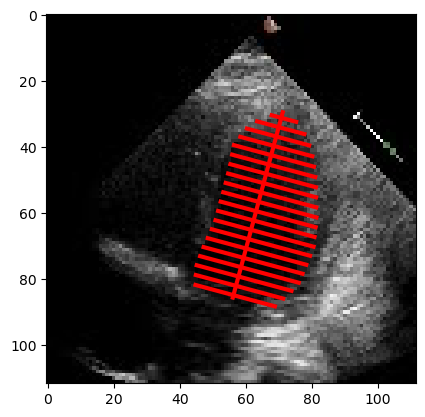

In [15]:
NUM_KEYPOINTS = 84
trace_df = pd.read_csv(OUTPUT_DIR.joinpath('0XB5CECBD29920B7B.csv'))
arr = PIL.Image.open(str(OUTPUT_DIR.joinpath('0XB5CECBD29920B7B_ED.png')))
plt.imshow(arr)
df = trace_df.query('Image == "0XB5CECBD29920B7B_ED.png"')
print(df.iloc[0][0])
for i in range(0, NUM_KEYPOINTS, 4):
    x1, y1 = df.iloc[0][i], df.iloc[0][i+1]
    x2, y2 = df.iloc[0][i+2], df.iloc[0][i+3]
    plt.plot([x1, x2], [y1, y2], color='red', linewidth=3)
plt.show()

In [16]:
trace_df

0          1          2          3          4          5  \
0  56.000000  85.531250  71.130208  29.385417  67.796322  30.284437   
1  53.447917  84.255208  68.031250  27.927083  64.783133  28.605878   

           6          7          8         9  ...         76         77  \
0  75.205312  32.281015  63.388392  32.13038  ...  44.798181  78.695195   
1  72.119858  30.505354  61.401818  30.76992  ...  43.705044  77.859099   

          78         79         80         81         82         83  \
0  71.267747  85.828228  44.697955  81.701981  68.745499  88.182326   
1  66.272263  83.701744  43.435083  80.828669  64.406727  86.258220   

                      Image  Split  
0  0XB5CECBD29920B7B_ED.png  TRAIN  
1  0XB5CECBD29920B7B_ES.png  TRAIN  

[2 rows x 86 columns]

### Build a Key Point Detection Model

In [17]:
# Models 
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten

In [18]:
NUM_KEYPOINTS=84
IMAGE_SIZE = 112
OUTPUT_DIR = Path('/kaggle/working/Output')
EPOCHS=50

The convenience function will load the training, testing, or test data as needed

In [107]:
## Load all the images and the keypoints
def LoadData(input_dir, type='TRAIN'):
    all_images = []
    all_points = []
    all_ids = []
    for j, p in enumerate(input_dir.glob(f"*.csv")):
        df = pd.read_csv(p)
        try:
            df_type = df.Split.unique()[0]
        except AttributeError:
            print(df)
            break
        if df_type == type:
            for i, x in enumerate(df.Image):
                img = PIL.Image.open(input_dir.joinpath(x))
                #plt.imshow(img)
                #plt.show()
                v = df.iloc[i][:NUM_KEYPOINTS]
                if len(v) != 84:
                    continue
                all_points.append(v)
                img = cv2.resize(np.asarray(img), (IMAGE_SIZE, IMAGE_SIZE))
                all_images.append(img)
                all_ids.append(p.name.split('.')[0])
    all_images = np.asarray(all_images)
    all_points = np.asarray(all_points)
    all_points = all_points.reshape(-1, 1, 1, NUM_KEYPOINTS) / IMAGE_SIZE
    all_ids = np.asarray(all_ids)
    return all_images, all_points, all_ids

Load the training data into memory

Convert the datatype for the keypoints to float32. By default it takes float64, that MobileNetV2 does not like,

In [132]:
train_images, train_keypoints, train_ids = LoadData(OUTPUT_DIR)
pp.pprint(train_images.shape)
pp.pprint(train_keypoints.shape)
train_keypoints_conv = train_keypoints.astype('float32')

(14918, 112, 112, 3)
(14918, 1, 1, 84)


In [92]:
def VisualizeSampleImages(image, kps, col='red'):
    plt.imshow(image)
    for i in range(0, NUM_KEYPOINTS, 4):
        x1, y1 = kps[0][i], kps[0][i+1]
        x2, y2 = kps[0][i+2], kps[0][i+3]
        plt.plot([x1, x2], [y1, y2], color=col, linewidth=2)
    #plt.show()

Visualize sample training images

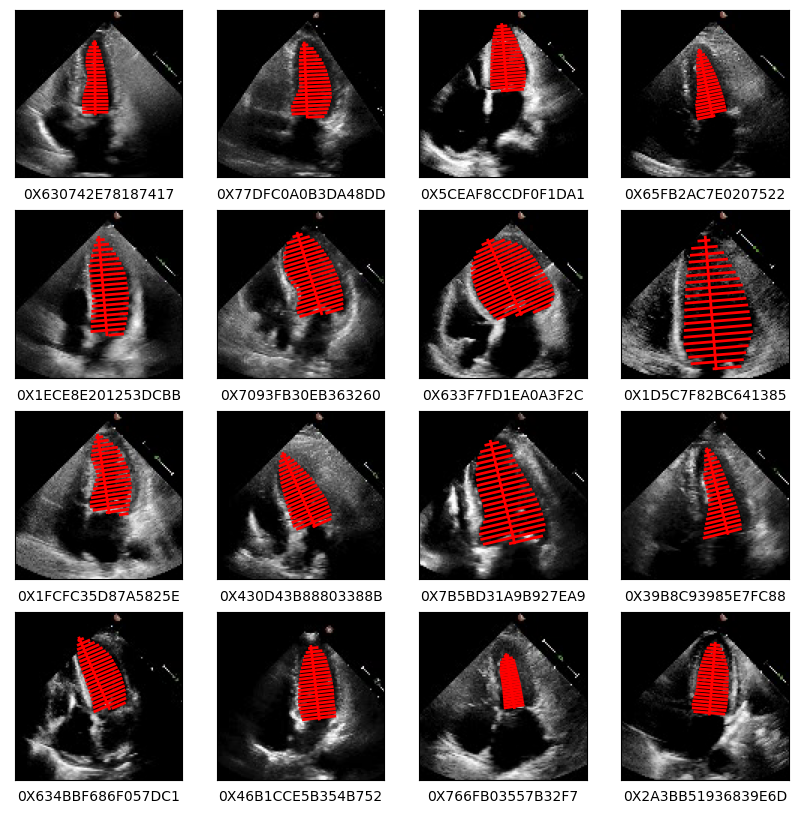

In [145]:
plt.subplots(4, 4, figsize=(10,10))
num_total = train_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    kps = train_keypoints_conv[k].reshape(-1, NUM_KEYPOINTS) * IMAGE_SIZE
    image = train_images[k]
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, kps)
    plt.xlabel(train_ids[k])

In [94]:
def VisualizeInstanceData(data_images, data_keypoints, data_ids, ED_index, ES_index):
    print(f"Data id {data_ids[ED_index]}")
    plt.subplots(1, 2, figsize=(8, 8))
    plt.subplot(1, 2, 1)
    img = data_images[ED_index]
    kps = data_keypoints[ED_index].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, kps)
    plt.xlabel("ED image")
    plt.subplot(1, 2, 2)
    img = data_images[ES_index]
    kps = data_keypoints[ES_index].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, kps)
    plt.xlabel("ES image")

The following ids have incorrect volume traces and will be removed\
0X354B37A25C64276F\
0X973E4A9DAADDF9F\
0X37F9E9981E207C04\
0X766B7B0ABDB07CD5\
0X5B6FCBB75BF8FCB7\
0X36C5A15AC7FC6AAA\
0X4BBA9C8FB485C9AB\
0X49EC1927F5747B19\
0X5D38D994C2490EAE\
0X53C185263415AA4F\
0X65E605F203321860\
0X753AA26EA352BBB

In [134]:
train_error_list = ['0X354B37A25C64276F','0X973E4A9DAADDF9F','0X37F9E9981E207C04','0X766B7B0ABDB07CD5',
'0X5B6FCBB75BF8FCB7','0X36C5A15AC7FC6AAA','0X4BBA9C8FB485C9AB','0X49EC1927F5747B19','0X5D38D994C2490EAE',
'0X53C185263415AA4F','0X65E605F203321860','0X753AA26EA352BBB']

In [144]:
x = [np.where(train_ids == inst)[0].tolist() for inst in train_error_list]
#flat_list = list(np.concatenate(x).flat)
print(x)

[[], [], [], [], [], [], [], [], [], [], [], []]


Data id 0X354B37A25C64276F


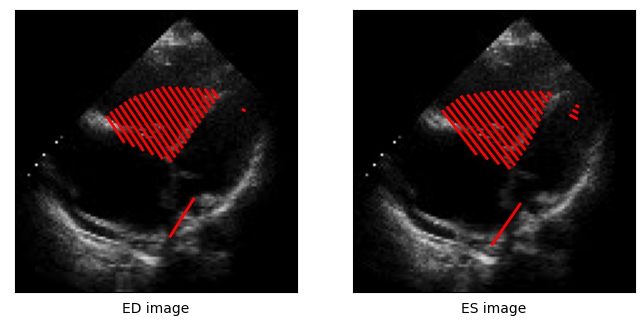

Data id 0X973E4A9DAADDF9F


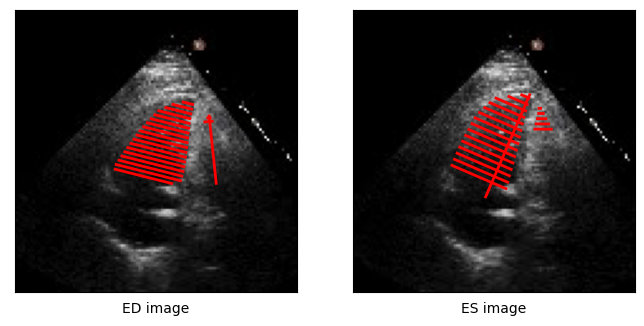

Data id 0X37F9E9981E207C04


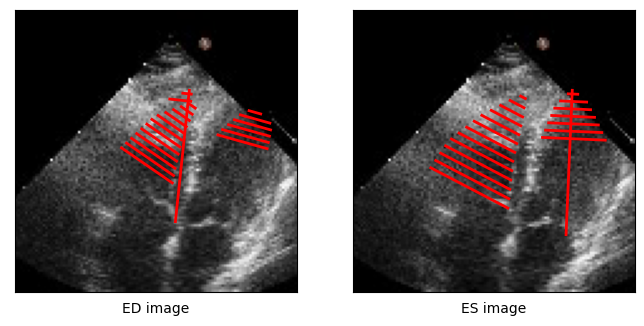

Data id 0X766B7B0ABDB07CD5


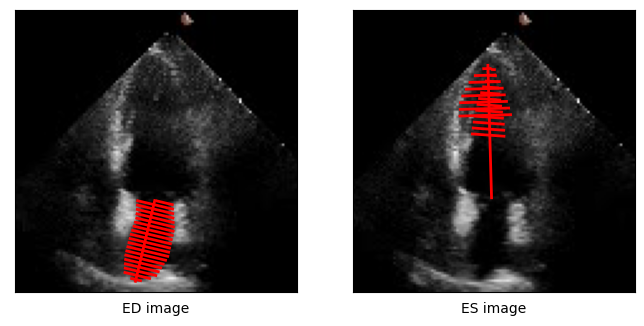

Data id 0X5B6FCBB75BF8FCB7


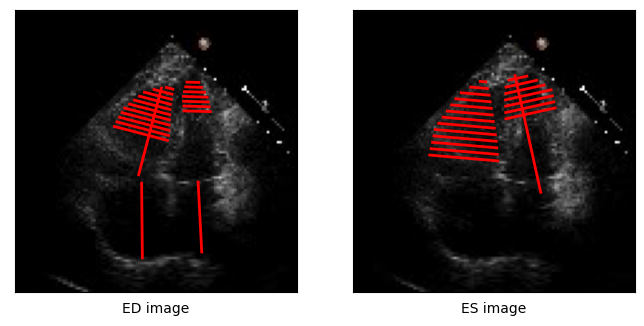

Data id 0X36C5A15AC7FC6AAA


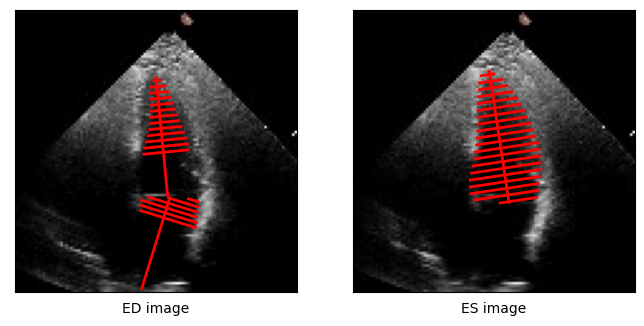

Data id 0X4BBA9C8FB485C9AB


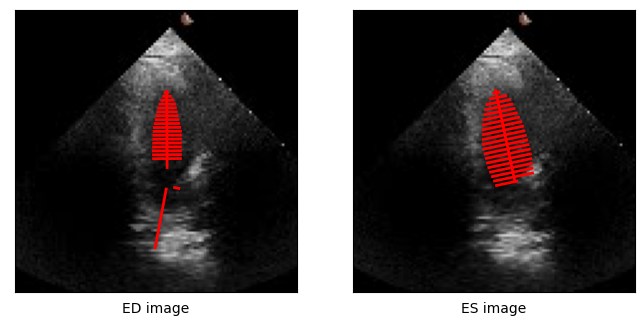

Data id 0X49EC1927F5747B19


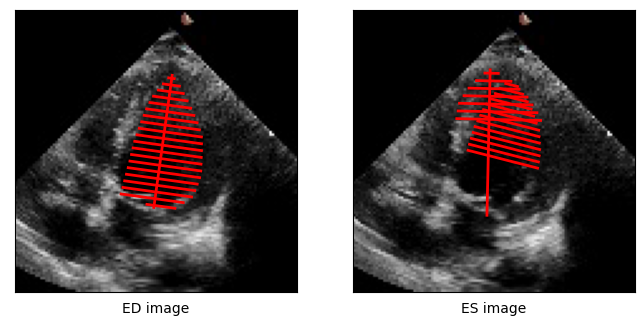

Data id 0X5D38D994C2490EAE


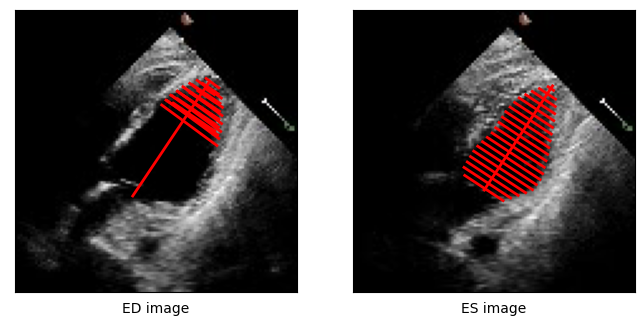

Data id 0X53C185263415AA4F


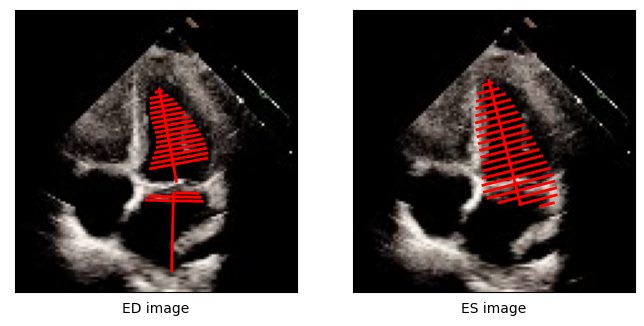

Data id 0X65E605F203321860


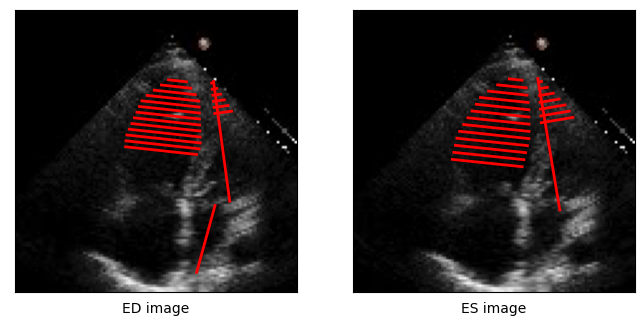

Data id 0X753AA26EA352BBB


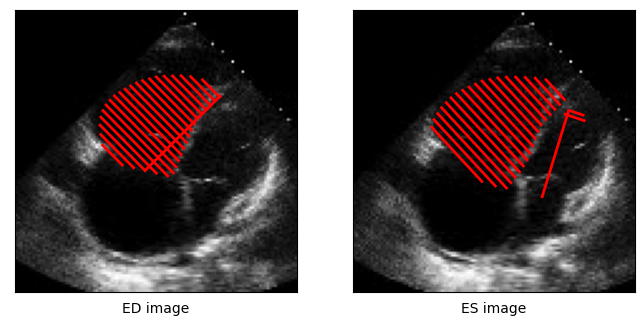

In [136]:
for i, j in x:
    VisualizeInstanceData(train_images, train_keypoints_conv, train_ids, i, j)
    plt.show()

Remove the incorrect volume traces from the training dataset

In [137]:
flat_list = list(np.concatenate(x).flat)
train_keypoints_conv = np.delete(train_keypoints_conv, flat_list, 0)
train_images = np.delete(train_images, flat_list, 0)
train_ids = np.delete(train_ids, flat_list, 0)

#### Build the model for training

I am using the MobileNetv2 from keras applications as the backbone.

Using the imagenet weights, I do a transfer learning using a new head that detects the keypoints for the Echo images. There are 42 points to detect.

In [147]:
IMAGE_SIZE=112
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

In [148]:
MODEL_NAME = 'LV_Cavity_Volume_Trace'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# Separable Convolutional Operation
x = SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, activation='relu', data_format='channels_last', name="ConvPass")(x)
# Outputs
outputs = SeparableConv2D(NUM_KEYPOINTS, kernel_size=2, activation='sigmoid', data_format='channels_last', name="OutputLayer")(x)
#Model
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()

Model: "LV_Cavity_Volume_Trace"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 112, 112, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 112, 112, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 112, 112, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 DropOut (Dropout)           (None, 4, 4, 1280)        0         
                                            

Load the validation images

In [140]:
val_images, val_keypoints, val_ids = LoadData(OUTPUT_DIR, type='VAL')
pp.pprint(val_images.shape)
pp.pprint(val_keypoints.shape)
val_keypoints_conv = val_keypoints.astype('float32')

(2576, 112, 112, 3)
(2576, 1, 1, 84)


In [149]:
# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# Optimizer 
from tensorflow.keras.optimizers import Adam

In [146]:
class ShowProgress(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 4, figsize=(10, 10))
            for i, k in enumerate(np.random.randint(num_total, size=2)):
                img = train_images[k]
                img = img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
                pred_kps = self.model.predict(img)
                pred_kps = pred_kps.reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
                kps = train_keypoints_conv[k].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
                plt.subplot(1, 4, 2*i+1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(img[0], pred_kps, col='#16a085')
                plt.xlabel(f"Predicted")
                plt.subplot(1, 4, 2*i+2)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(img[0], kps)
                plt.xlabel(f"GT:{train_ids[k]}")
            plt.show()

Train

In [142]:
WEIGHT_DIR = Path('/kaggle/working/Weights')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

Epoch 1/200


2023-04-10 21:18:08.929167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inLV_Cavity_Volume_Trace/DropOut/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 24ms/step


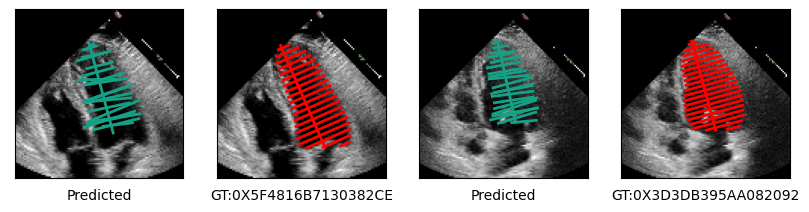

466/466 [==============================] - 11s 17ms/step - loss: 0.0645 - val_loss: 0.0452
Epoch 2/200
466/466 [==============================] - 7s 14ms/step - loss: 0.0396 - val_loss: 0.0376
Epoch 3/200
466/466 [==============================] - 7s 14ms/step - loss: 0.0355 - val_loss: 0.0350
Epoch 4/200
466/466 [==============================] - 7s 14ms/step - loss: 0.0335 - val_loss: 0.0332
Epoch 5/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 6/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 7/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 8/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0305 - val_loss: 0.0308
Epoch 9/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 10/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0297 - val_los

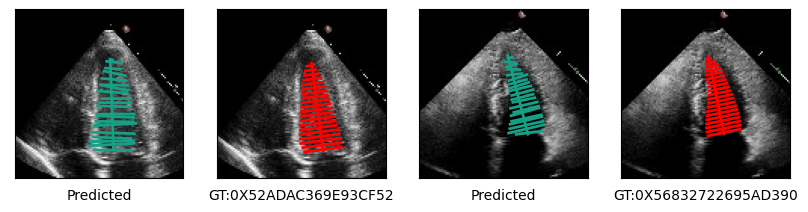

466/466 [==============================] - 7s 15ms/step - loss: 0.0274 - val_loss: 0.0287
Epoch 22/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0273 - val_loss: 0.0284
Epoch 23/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0271 - val_loss: 0.0285
Epoch 24/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0270 - val_loss: 0.0283
Epoch 25/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0270 - val_loss: 0.0282
Epoch 26/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0268 - val_loss: 0.0283
Epoch 27/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 28/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0266 - val_loss: 0.0281
Epoch 29/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0265 - val_loss: 0.0280
Epoch 30/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0264 - 

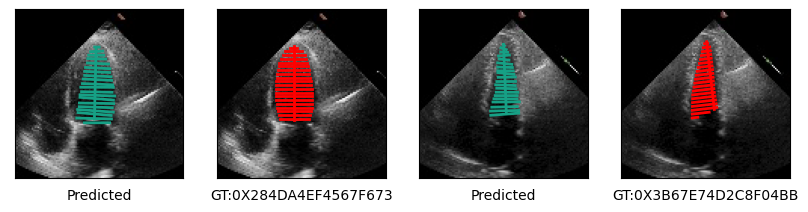

466/466 [==============================] - 6s 14ms/step - loss: 0.0253 - val_loss: 0.0277
Epoch 42/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0253 - val_loss: 0.0276
Epoch 43/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0252 - val_loss: 0.0274
Epoch 44/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 45/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0251 - val_loss: 0.0275
Epoch 46/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0250 - val_loss: 0.0274
Epoch 47/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0249 - val_loss: 0.0274
Epoch 48/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0249 - val_loss: 0.0275
Epoch 49/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0248 - val_loss: 0.0274
Epoch 50/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0247 - 

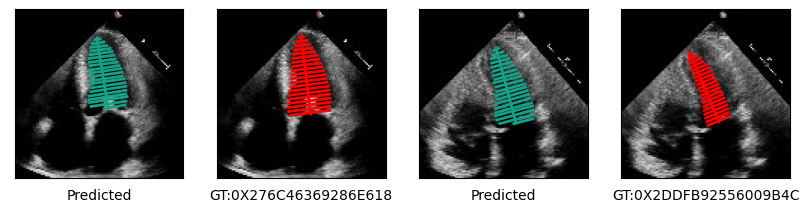

466/466 [==============================] - 6s 13ms/step - loss: 0.0240 - val_loss: 0.0273
Epoch 62/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0239 - val_loss: 0.0272
Epoch 63/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0239 - val_loss: 0.0273
Epoch 64/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0238 - val_loss: 0.0272
Epoch 65/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0238 - val_loss: 0.0274
Epoch 66/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0238 - val_loss: 0.0272
Epoch 67/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0237 - val_loss: 0.0273
Epoch 68/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0236 - val_loss: 0.0272
Epoch 69/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0236 - val_loss: 0.0272
Epoch 70/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0235 - 

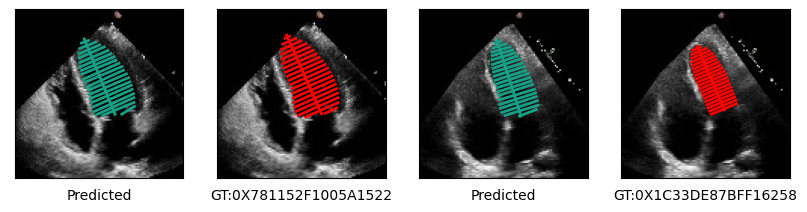

466/466 [==============================] - 7s 15ms/step - loss: 0.0231 - val_loss: 0.0272
Epoch 82/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0229 - val_loss: 0.0272
Epoch 83/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0230 - val_loss: 0.0273
Epoch 84/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0228 - val_loss: 0.0273
Epoch 85/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0228 - val_loss: 0.0273
Epoch 86/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0228 - val_loss: 0.0273
Epoch 87/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0228 - val_loss: 0.0272
Epoch 88/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0227 - val_loss: 0.0272
Epoch 89/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0226 - val_loss: 0.0272
Epoch 90/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0226 - 

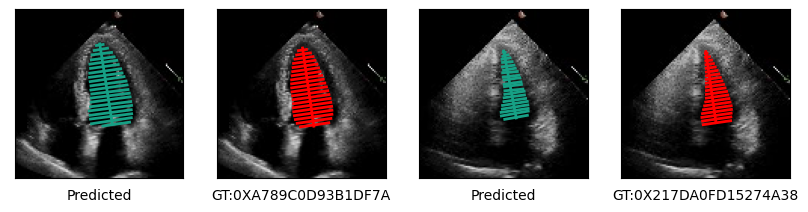

466/466 [==============================] - 6s 13ms/step - loss: 0.0222 - val_loss: 0.0273
Epoch 102/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0222 - val_loss: 0.0272
Epoch 103/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0222 - val_loss: 0.0272
Epoch 104/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0222 - val_loss: 0.0273
Epoch 105/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0221 - val_loss: 0.0274
Epoch 106/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0220 - val_loss: 0.0273
Epoch 107/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0220 - val_loss: 0.0273
Epoch 108/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0220 - val_loss: 0.0273
Epoch 109/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0219 - val_loss: 0.0273
Epoch 110/200
466/466 [==============================] - 5s 11ms/step - loss: 

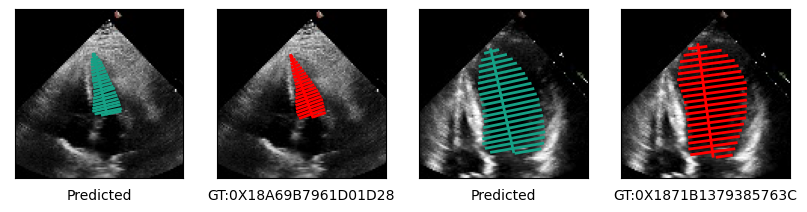

466/466 [==============================] - 6s 12ms/step - loss: 0.0216 - val_loss: 0.0274
Epoch 122/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0216 - val_loss: 0.0274
Epoch 123/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0216 - val_loss: 0.0274
Epoch 124/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0216 - val_loss: 0.0275
Epoch 125/200
466/466 [==============================] - 7s 14ms/step - loss: 0.0216 - val_loss: 0.0273
Epoch 126/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0215 - val_loss: 0.0275
Epoch 127/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0215 - val_loss: 0.0274
Epoch 128/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0214 - val_loss: 0.0275
Epoch 129/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0214 - val_loss: 0.0274
Epoch 130/200
466/466 [==============================] - 6s 13ms/step - loss: 

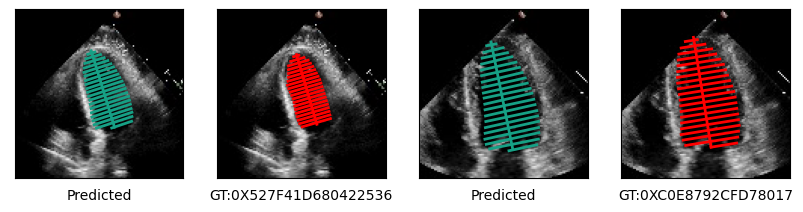

466/466 [==============================] - 6s 13ms/step - loss: 0.0212 - val_loss: 0.0274
Epoch 142/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0211 - val_loss: 0.0275
Epoch 143/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0211 - val_loss: 0.0275
Epoch 144/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0211 - val_loss: 0.0276
Epoch 145/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0211 - val_loss: 0.0275
Epoch 146/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0210 - val_loss: 0.0276
Epoch 147/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0210 - val_loss: 0.0276
Epoch 148/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0210 - val_loss: 0.0276
Epoch 149/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0210 - val_loss: 0.0275
Epoch 150/200
466/466 [==============================] - 6s 13ms/step - loss: 

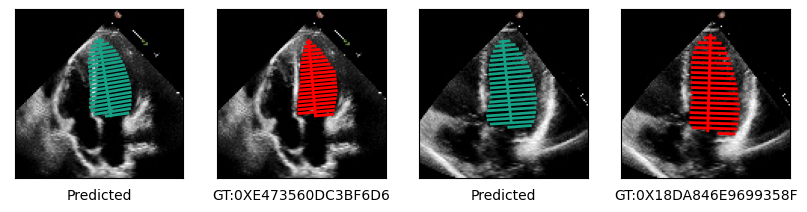

466/466 [==============================] - 6s 14ms/step - loss: 0.0207 - val_loss: 0.0276
Epoch 162/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0207 - val_loss: 0.0277
Epoch 163/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0207 - val_loss: 0.0277
Epoch 164/200
466/466 [==============================] - 5s 12ms/step - loss: 0.0207 - val_loss: 0.0276
Epoch 165/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0207 - val_loss: 0.0277
Epoch 166/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0207 - val_loss: 0.0278
Epoch 167/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0207 - val_loss: 0.0277
Epoch 168/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0206 - val_loss: 0.0276
Epoch 169/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0206 - val_loss: 0.0276
Epoch 170/200
466/466 [==============================] - 6s 13ms/step - loss: 

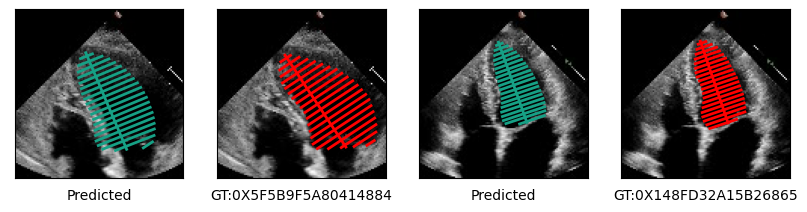

466/466 [==============================] - 6s 13ms/step - loss: 0.0205 - val_loss: 0.0276
Epoch 182/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 183/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 184/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 185/200
466/466 [==============================] - 6s 12ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 186/200
466/466 [==============================] - 5s 11ms/step - loss: 0.0203 - val_loss: 0.0278
Epoch 187/200
466/466 [==============================] - 6s 13ms/step - loss: 0.0204 - val_loss: 0.0277
Epoch 188/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0203 - val_loss: 0.0278
Epoch 189/200
466/466 [==============================] - 6s 14ms/step - loss: 0.0203 - val_loss: 0.0278
Epoch 190/200
466/466 [==============================] - 5s 12ms/step - loss: 

In [150]:
EPOCHS=200
# Compile
model_1.compile(loss='mae', optimizer=Adam(learning_rate=1e-4)) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
history = model_1.fit(train_images, train_keypoints_conv, 
                      validation_data=(val_images, val_keypoints_conv), 
                      epochs=EPOCHS, 
                      callbacks=callbacks)

Visualize Loss Curve

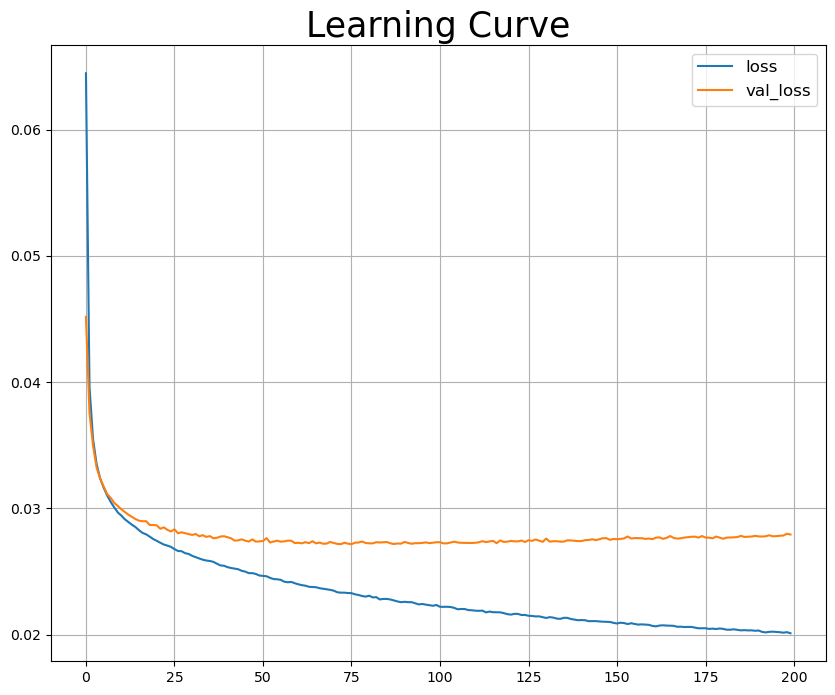

In [151]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

Observing the model outputs, it looks like it captures the left ventricle area very well. Also the scaling of the volume tracing points is nicely captured. The lines are parallel as expected. However, the long axis line are not always perpendicular to the parallel lines, as seen in some of the cases.
Also it does not capture the deformations in the left ventricle. The model needs a convolution layer that can capture deformations of the left ventricle across the images

## Evaluation on Test Data

In [154]:
from tensorflow.train import latest_checkpoint
latest = latest_checkpoint('/kaggle/working')
latest

'/kaggle/working/WeightsLV_Cavity_Volume_Trace-0073.ckpt'

In [153]:
test_images, test_keypoints, test_ids = LoadData(OUTPUT_DIR, type='TEST')
pp.pprint(test_images.shape)
pp.pprint(test_keypoints.shape)
test_keypoints_conv = test_keypoints.astype('float32')

(2552, 112, 112, 3)
(2552, 1, 1, 84)


In [155]:
def evaluate_model(model, data_images, data_keypoints):
    loss = model.evaluate(data_images, data_keypoints, verbose=2)
    return loss

In [156]:
model_2 = Model(inputs, outputs, name=MODEL_NAME)
model_2.compile(loss='mae', optimizer=Adam(learning_rate=1e-4))
model_2.load_weights(latest)

In [157]:
print(f"Loss for training images : {evaluate_model(model_2, train_images, train_keypoints_conv)}")
print(f"Loss for validation images : {evaluate_model(model_2, val_images, val_keypoints_conv)}")
print(f"Loss for testing images : {evaluate_model(model_2, test_images, test_keypoints_conv)}")

466/466 - 5s - loss: 0.0211 - 5s/epoch - 12ms/step
Loss for training images : 0.02110641449689865
81/81 - 1s - loss: 0.0272 - 790ms/epoch - 10ms/step
Loss for validation images : 0.027160143479704857
80/80 - 1s - loss: 0.0267 - 861ms/epoch - 11ms/step
Loss for testing images : 0.026665162295103073


1/1 [==============================] - 0s 27ms/step


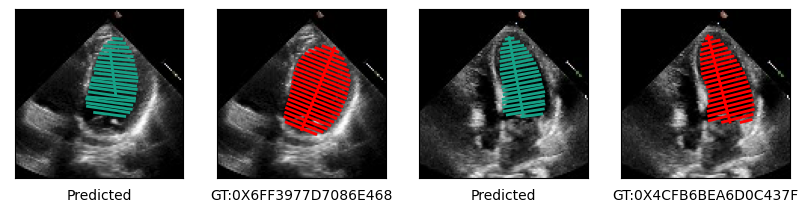

In [158]:
test_total = test_images.shape[0]
plt.subplots(1, 4, figsize=(10, 10))
for i, k in enumerate(np.random.randint(test_total, size=2)):
    img = test_images[k]
    img = img.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    pred_kps = model_2.predict(img)
    pred_kps = pred_kps.reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    kps = test_keypoints[k].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    plt.subplot(1, 4, 2*i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img[0], pred_kps, col='#16a085')
    plt.xlabel(f"Predicted")
    plt.subplot(1, 4, 2*i+2)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img[0], kps)
    plt.xlabel(f"GT:{train_ids[k]}")

## Calculate the Ejection Fraction using the Volume Tracings

Add some utility functions for the calculation

In [167]:
import math

In [159]:
def calculate_disk_area(x1, y1, x2, y2):
    dist = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
    r = dist/2
    area = np.pi * r * r
    return area
    

In [187]:
def calculate_volume(keypoints):
    '''
        keypoints: shape is [1, NUM_KEYPOINTS]
    '''
    ## first 4 is the long axis points
    x1, y1, x2, y2 = keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3]
    distance = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
    height_of_disk = distance/20
    accumalated_areas = []
    for i in range(4, NUM_KEYPOINTS, 4):
        accumalated_areas.append(calculate_disk_area(keypoints[0][i], keypoints[0][i+1], 
                                                     keypoints[0][i+2], keypoints[0][i+3]))
        
    xa, ya, xb, yb = keypoints[0][4], keypoints[0][5], keypoints[0][6], keypoints[0][7]
    xc, yc, xd, yd = keypoints[0][8], keypoints[0][9], keypoints[0][10], keypoints[0][11]
    ## Calculate the distance between the 2 adjacent parallel lines. This will be alternate height of 
    ## the disk
    m = (yb-ya)/(xb-xa)
    c1 = yb - m*xb
    c2 = yd - m*xd
    alt_height_of_disk = abs(c1-c2)/math.sqrt(1+m*m)
    volume = sum(accumalated_areas)*height_of_disk
    return volume

In [161]:
def calculate_EF(ED_keypoints, ES_keypoints):
    '''
        ED_keypoints: shape [1, NUM_KEYPOINTS]
        ES_keypoints: shape [1, NUM_KEYPOINTS]
    '''
    ED_volume = calculate_volume(ED_keypoints)
    ES_volume = calculate_volume(ES_keypoints)
    EF = ((ED_volume - ES_volume) / ED_volume) * 100
    return EF

In [162]:
def calculate_EFs(data_keypoints):
    '''
    data_keypoints: shape [None, 1, 1, NUM_KEYPOINTS]
    '''
    total = data_keypoints.shape[0]
    data_EFs = []
    for i in range(0, total, 2):
        ED_kps = data_keypoints[i].reshape(-1, NUM_KEYPOINTS) * IMAGE_SIZE
        ES_kps = data_keypoints[i+1].reshape(-1, NUM_KEYPOINTS) * IMAGE_SIZE
        EF = calculate_EF(ED_kps, ES_kps)
        data_EFs.append(EF)
    return data_EFs

In [163]:
def build_dataframe_EFs(calculated_kps, predicted_kps):
    '''
        calculated_kps: shape [None, 1, 1, NUM_KEYPOINTS]
        predicted_kps: shape [None, 1, 1, NUM_KEYPOINTS]
    '''
    cal_efs = calculate_EFs(calculated_kps)
    pred_efs = calculate_EFs(predicted_kps)
    d = {'Actual_EF': cal_efs, 'Pred_EF': pred_efs}
    df = pd.DataFrame(data=d)
    act_lvef_class = []
    for i in df.Actual_EF:
        if i >= 50:
            act_lvef_class.append('Normal')
        elif i > 40:
            act_lvef_class.append('Mild')
        else:
            act_lvef_class.append('Abnormal')
    act_lvef_class = pd.Series(act_lvef_class, name='Actual_HFClass')
    act_lvef_class = act_lvef_class.astype('category')
    act_lvef_class = act_lvef_class.cat.set_categories(["Normal", "Mild", "Abnormal"], ordered=True)
    df['Actual_HFClass'] = act_lvef_class
    pred_lvef_class = []
    for i in df.Pred_EF:
        if i >= 50:
            pred_lvef_class.append('Normal')
        elif i > 40:
            pred_lvef_class.append('Mild')
        else:
            pred_lvef_class.append('Abnormal')
    pred_lvef_class = pd.Series(pred_lvef_class, name='Actual_HFClass')
    pred_lvef_class = pred_lvef_class.astype('category')
    pred_lvef_class = pred_lvef_class.cat.set_categories(["Normal", "Mild", "Abnormal"], ordered=True)
    df['Pred_HFClass'] = pred_lvef_class
    df['Diff_EFs'] = np.abs(df.Actual_EF - df.Pred_EF)
    return df

In [164]:
def get_predicted_points(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

Get the predicted keypoints for training, validation and test images

In [165]:
predicted_train_kps = get_predicted_points(train_images, model_2)
predicted_val_kps = get_predicted_points(val_images, model_2)
predicted_test_kps = get_predicted_points(test_images, model_2)

80/80 [==============================] - 1s 9ms/step


Get the dataframe of the actual and predicted efs. Note that I am not taking the EF values from the original data, but calculated it from the original volume tracings. This will be compared to the EF values from the predicted volume tracings.

In [188]:
training_output_df = build_dataframe_EFs(train_keypoints_conv, predicted_train_kps)
val_output_df = build_dataframe_EFs(val_keypoints_conv, predicted_val_kps)
test_output_df = build_dataframe_EFs(test_keypoints_conv, predicted_test_kps)

I calculate the EF values for the training, validation, and test images and build a dataframe, which is visualized below.

In [189]:
training_output_df.head()
    

Actual_EF    Pred_EF Actual_HFClass Pred_HFClass   Diff_EFs
0  36.364804  24.034981       Abnormal     Abnormal  12.329824
1  50.427255  45.741364         Normal         Mild   4.685891
2  67.411209  59.440439         Normal       Normal   7.970770
3  61.178580  54.528223         Normal       Normal   6.650357
4  38.143818  24.655676       Abnormal     Abnormal  13.488141

In [190]:
val_output_df.head()

Actual_EF    Pred_EF Actual_HFClass Pred_HFClass   Diff_EFs
0  46.615554  63.783899           Mild       Normal  17.168345
1  58.190703  65.035587         Normal       Normal   6.844885
2  58.315702  52.773657         Normal       Normal   5.542045
3  59.537594  76.874598         Normal       Normal  17.337004
4  50.390203  57.806630         Normal       Normal   7.416427

In [191]:
test_output_df.head()

Actual_EF    Pred_EF Actual_HFClass Pred_HFClass   Diff_EFs
0  61.041832  58.550360         Normal       Normal   2.491472
1  40.782594   4.544609           Mild     Abnormal  36.237984
2  52.297182  73.908143         Normal       Normal  21.610961
3  57.973358  27.325225         Normal     Abnormal  30.648133
4  45.602962  22.857180           Mild     Abnormal  22.745782

I see some negative EF values. Looking at 1 case with negative value, it looks like the long axis is not correct.

In [175]:
def VisualizeSingleData(data_images, data_keypoints, pred_keypoints, data_ids, index):
    print(f"Data id {data_ids[2*index]}")
    plt.subplots(1, 4, figsize=(12, 12))
    img = data_images[2*index]
    pred_kps = pred_keypoints[2*index].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    kps = data_keypoints[2*index].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    plt.subplot(1, 4, 1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, pred_kps, col='#16a085')
    plt.xlabel(f"Predicted")
    plt.subplot(1, 4, 2)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, kps)
    img = data_images[2*index+1]
    pred_kps = pred_keypoints[2*index+1].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    kps = data_keypoints[2*index+1].reshape(-1,NUM_KEYPOINTS) * IMAGE_SIZE
    plt.xlabel(f"GT:{data_ids[2*index+1]}")
    plt.subplot(1, 4, 3)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, pred_kps, col='#16a085')
    plt.xlabel(f"Predicted")
    plt.subplot(1, 4, 4)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(img, kps)
    plt.xlabel(f"GT:{data_ids[2*index+1]}")

In [193]:
error_list = training_output_df.query('Actual_EF < 0').index.tolist()    
## Errors in training data
for i, err in enumerate(error_list):
    VisualizeSingleData(train_images, train_keypoints_conv, predicted_train_kps, train_ids, err)
    plt.show()

Data id 0X4154F112065C857B


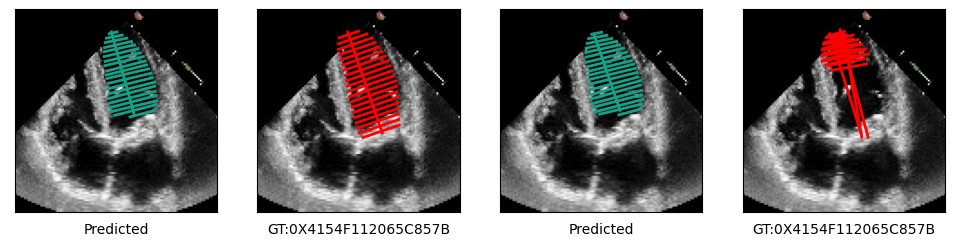

In [192]:
error_list_val = val_output_df.query('Actual_EF < 0').index.tolist()
## Errors in validation data
for err in error_list_val:
    VisualizeSingleData(val_images, val_keypoints_conv, predicted_val_kps, val_ids, err)
    plt.show()

Data id 0X500FC4E8716B0A8F


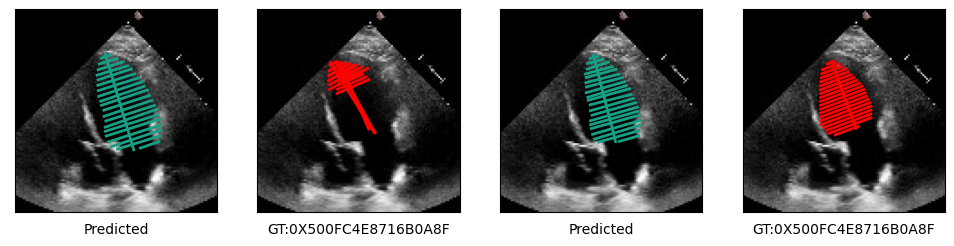

In [194]:
error_list_test = test_output_df.query('Actual_EF < 0').index.tolist()
## Errors in validation data
for err in error_list_test:
    VisualizeSingleData(test_images, test_keypoints_conv, predicted_test_kps, test_ids, err)
    plt.show()

241
-4.9387650448443186
Data id 0X1B53202748E0AB3F


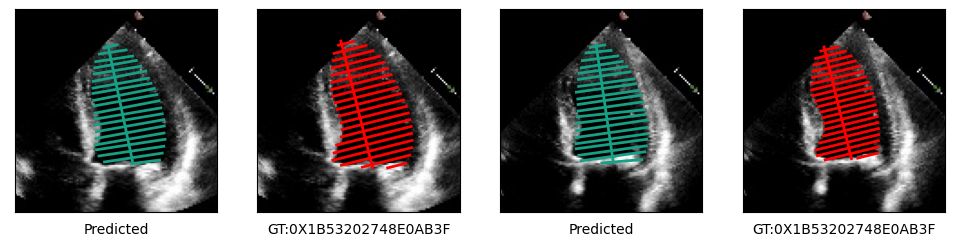

-13.897019167331345
Data id 0X1CC5A2587BAEBD73


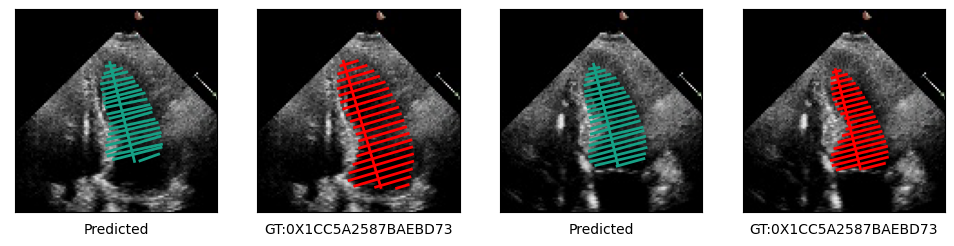

-20.75420593446597
Data id 0X465E766F162C7A19


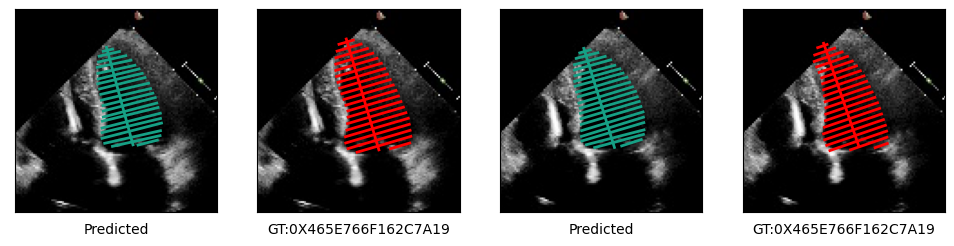

-36.76439708296505
Data id 0X66F7B3D066CDBF3B


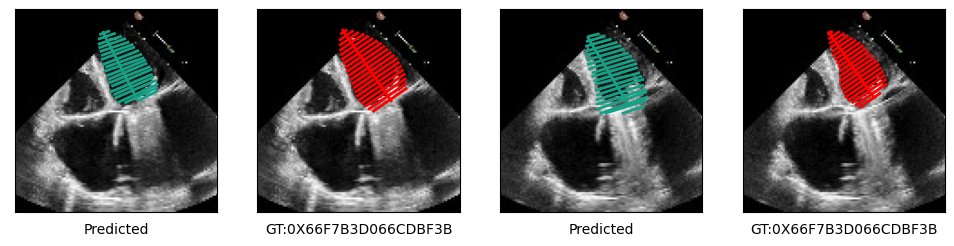

-16.826213969028277
Data id 0X3B62B3502E5549A


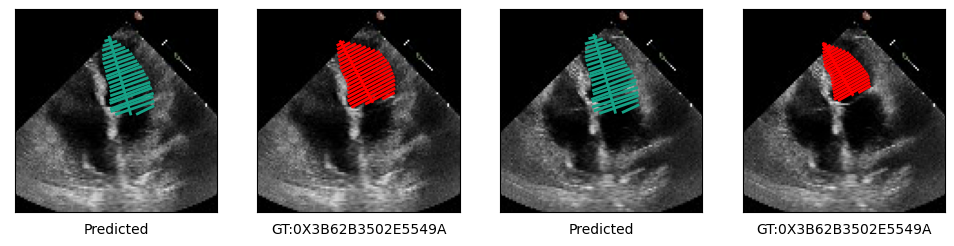

-7.559294975118702
Data id 0X2BF77B6A39CD9A0B


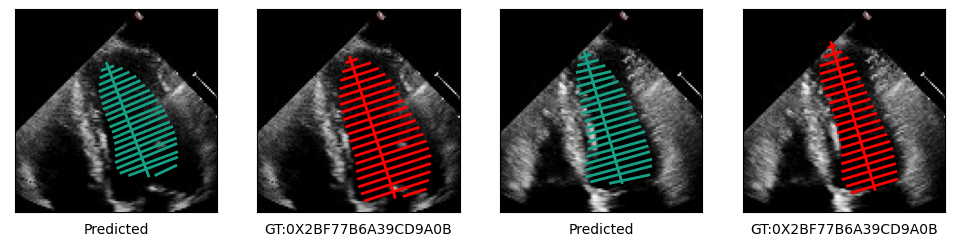

-7.540056236332575
Data id 0X3BF45BED0E9423D0


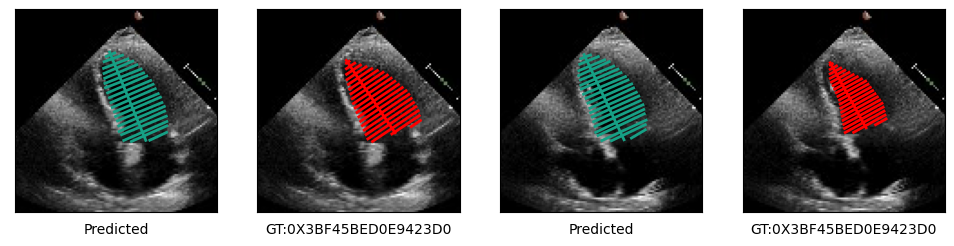

In [196]:
error_list = training_output_df.query('Pred_EF < 0').index.tolist()
print(len(error_list))
## Errors in Training data
for i, err in enumerate(error_list):
    print(training_output_df.Pred_EF[err])
    VisualizeSingleData(train_images, train_keypoints_conv, predicted_train_kps, train_ids, err)
    plt.show()
    if i == 6:
        break

## Error Analysis

In [197]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

Confusion Matrix for Training Data

In [198]:
print('Confusion Matrix for Training Data')
Accuracy_ConfusionMatrix(training_output_df.Actual_HFClass, 
                         training_output_df.Pred_HFClass,
                         training_output_df.Actual_HFClass.cat.categories)

Confusion Matrix for Training Data
Accuracy of model: 0.5939304417886397
Predicted  Normal  Mild  Abnormal
Actual                           
Normal       3508  1071      1128
Mild          232   178       337
Abnormal      111   145       737
Sensitivity of model for individual classes
Class Normal : 0.6146837217452251
Class Mild : 0.23828647925033467
Class Abnormal : 0.7421953675730111


Confusion Matrix for Validation Data

In [199]:
print('Confusion Matrix for Validation Data')
Accuracy_ConfusionMatrix(val_output_df.Actual_HFClass, 
                         val_output_df.Pred_HFClass,
                         val_output_df.Actual_HFClass.cat.categories)

Confusion Matrix for Validation Data
Accuracy of model: 0.5388198757763976
Predicted  Normal  Mild  Abnormal
Actual                           
Normal        551   185       252
Mild           36    29        70
Abnormal       23    28       114
Sensitivity of model for individual classes
Class Normal : 0.5576923076923077
Class Mild : 0.21481481481481482
Class Abnormal : 0.6909090909090909


Confusion Matrix for Testing Data

In [200]:
print('Confusion Matrix for Testing Data')
Accuracy_ConfusionMatrix(test_output_df.Actual_HFClass, 
                         test_output_df.Pred_HFClass,
                         test_output_df.Actual_HFClass.cat.categories)

Confusion Matrix for Testing Data
Accuracy of model: 0.5525078369905956
Predicted  Normal  Mild  Abnormal
Actual                           
Normal        561   160       259
Mild           48    26        52
Abnormal       20    32       118
Sensitivity of model for individual classes
Class Normal : 0.5724489795918367
Class Mild : 0.20634920634920634
Class Abnormal : 0.6941176470588235


From the above values, it looks like the model performs worse on the mild class - ie EFs that are between 40 and 50.

Data id 0X1C64E294328A8F14


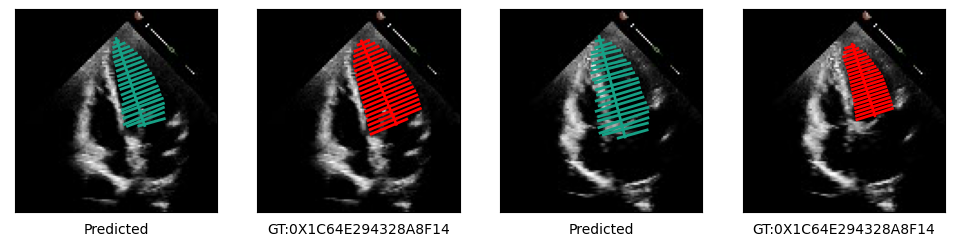

In [208]:
VisualizeSingleData(train_images, train_keypoints_conv, predicted_train_kps, train_ids, 531)

In [202]:
training_output_df.query('Diff_EFs > 100')

Actual_EF     Pred_EF Actual_HFClass Pred_HFClass    Diff_EFs
350   46.129548 -186.344720           Mild     Abnormal  232.474268
531   62.436191  -77.681337         Normal     Abnormal  140.117529
1009  72.454932  -64.429249         Normal     Abnormal  136.884181
1935  60.782001 -188.145711         Normal     Abnormal  248.927713
3175  63.237700  -57.399844         Normal     Abnormal  120.637545
3570  55.233136 -264.833474         Normal     Abnormal  320.066610
4170  58.994325 -394.096063         Normal     Abnormal  453.090388
4197  57.685827  -42.859549         Normal     Abnormal  100.545376
4335  45.695708 -171.888612           Mild     Abnormal  217.584320
4540  51.986768 -151.200142         Normal     Abnormal  203.186910
4781  59.191543  -46.744356         Normal     Abnormal  105.935899
5345  56.949173  -54.791418         Normal     Abnormal  111.740592
5643  58.377180  -41.730995         Normal     Abnormal  100.108174
6593  67.983551  -46.896113         Normal     Abnormal  114.879664
6773  52.870663  -52.348470         Normal     Abnormal  105.219133
7135  31.544354  -90.342207       Abnormal     Abnormal  121.886561
7171  32.003555  -78.384990       Abnormal     Abnormal  110.388545

<AxesSubplot:title={'center':'Diff_EFs'}, xlabel='Actual_HFClass'>

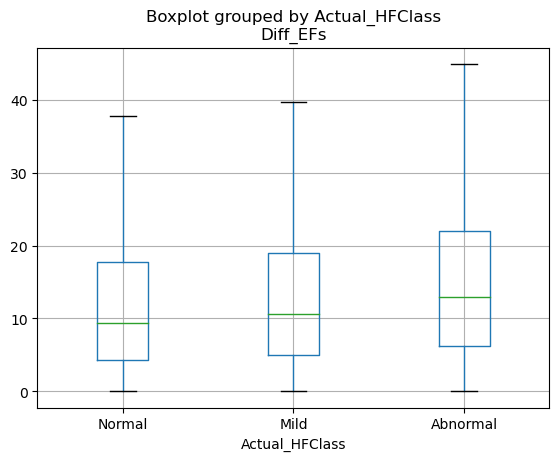

In [205]:
training_output_df.boxplot(column='Diff_EFs', by='Actual_HFClass', showfliers=False)